## SOCIAL NETWORK ANALYSIS
By Pranathi Nibhanipudi (CB.SC.U4CSE23643)

Analyzing UN General Assembly speeches to build and visualize a social network that reveals the influence and relationships between countries based on how often they mention one another.

Dataset link: https://www.kaggle.com/datasets/unitednations/un-general-debates/data

In [ ]:
import pandas as pd
import numpy as np
import re
from collections import Counter
import pycountry
from tqdm.notebook import tqdm
import networkx as nx
import matplotlib.pyplot as plt

In [3]:
df = pd.read_csv('un-general-debates.csv')

# STEP 1: DATA CLEANING

In [ ]:
# STEP 1.1: CONSOLIDATE SPEECHES SPLIT ACROSS MULTIPLE ROWS
# Some speeches are broken into multiple rows, with metadata only in the first row.
# We identify fragmented rows (where 'country' is null) and forward-fill the metadata.
df['country'].replace(r'^\s*$', np.nan, regex=True, inplace=True)
df[['session', 'year', 'country']] = df[['session', 'year', 'country']].ffill()

# Now we group by each unique speech (identified by session, year, and country)
# and join the fragmented text pieces back together into a single entry.
df = df.groupby(['session', 'year', 'country'])['text'].apply(' '.join).reset_index()


# STEP 1.2: CLEAN SPEECH TEXT
# Remove the numerical and country-code prefixes (e.g., "ALB 33: " or "177. : ") from the start of speeches.
df['text'] = df['text'].str.replace(r'^(?:[A-Z]{3}\s*)?\d+[\s\.:]+', '', regex=True)

# Remove all leading whitespace characters (including newlines and spaces) that might remain after cleaning.
df['text'] = df['text'].str.lstrip()

C:\Users\prana\AppData\Local\Temp\ipykernel_42264\426162205.py:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['country'].replace(r'^\s*$', np.nan, regex=True, inplace=True)


# STEP 2: STANDARDIZE COUNTRY NAMES (ISO TO FULL NAME)

In [44]:
# Get a unique list of all ISO codes present in the dataframe's 'country' column.
iso_codes = df['country'].unique()

# Create a mapping dictionary to convert ISO alpha-3 codes to common country names.
iso_map = {}
for code in iso_codes:
    try:
        # Look up the country name using the pycountry library.
        country = pycountry.countries.get(alpha_3=code)
        iso_map[code] = country.name
    except AttributeError:
        # If the code is not found (e.g., historical codes like 'YUG'), keep the code for manual mapping later.
        print(f"Warning: ISO code '{code}' not found. It will be left as is.")
        iso_map[code] = code

# Create a manual map for codes that pycountry couldn't find (historical, organizational, etc.).
manual_map = {
    'YDYE': 'South Yemen', # People's Democratic Republic of Yemen
    'CSK': 'Czechoslovakia',
    'YUG': 'Yugoslavia',
    'DDR': 'German Democratic Republic', # East Germany
    'EU': 'European Union'
}

# Update the main map with our manual fixes.
iso_map.update(manual_map)

# Apply the completed map to the 'country' column to create a new, standardized 'country_name' column.
df['country_name'] = df['country'].map(iso_map)

# Verify that all codes were successfully mapped.
missing_maps = df[df['country_name'].isnull()]
if not missing_maps.empty:
    print("\n--- Could not map the following codes: ---")
    print(missing_maps['country'].value_counts())
else:
    print("\nSuccessfully mapped all country codes!")


Successfully mapped all country codes!


# STEP 3: ALIAS DISCOVERY

In [45]:
# This regex finds sequences of one or more capitalized words (e.g., "United States").
capitalized_word_pattern = r'\b([A-Z][a-z]+(?:\s[A-Z][a-z]+)*)\b'

# Create a list to store all potential alias candidates found in the text.
all_candidates = []

# Iterate through every speech to find and collect these capitalized phrases.
for speech in df['text']:
    candidates = re.findall(capitalized_word_pattern, speech)
    all_candidates.extend(candidates)

# Count the frequency of each candidate to identify the most common ones for review.
candidate_counts = Counter(all_candidates)

print("--- Top 50 Most Common Capitalized Phrases ---")
print(candidate_counts.most_common(50))

--- Top 50 Most Common Capitalized Phrases ---
[('The', 98044), ('We', 94780), ('United Nations', 75239), ('In', 48083), ('It', 47570), ('States', 31975), ('Organization', 29266), ('This', 23835), ('General Assembly', 22950), ('Government', 21937), ('Security Council', 17900), ('Africa', 17888), ('General', 17040), ('State', 16113), ('Secretary', 15858), ('That', 14515), ('As', 13896), ('Mr', 13655), ('President', 12964), ('Assembly', 12709), ('Charter', 12458), ('Republic', 12395), ('Israel', 11666), ('Middle East', 11284), ('But', 11058), ('South Africa', 10363), ('United States', 10117), ('There', 9517), ('Our', 9027), ('At', 8790), ('Powers', 8774), ('For', 8709), ('Palestinian', 8645), ('My', 8607), ('African', 8020), ('However', 7682), ('Namibia', 7594), ('Europe', 7510), ('They', 7364), ('South', 7149), ('On', 7148), ('Arab', 7071), ('Member States', 6944), ('Iraq', 6893), ('To', 6572), ('Conference', 6003), ('These', 6000), ('Afghanistan', 5907), ('If', 5889), ('Council', 5434)

In [ ]:
# STEP 3.1: DEFINING IGNORE LIST
ignore_list = {
    # --- Common English Words (often capitalized at the start of sentences) ---
    'The', 'We', 'In', 'It', 'This', 'That', 'As', 'But', 'There', 'Our', 'At', 'For',
    'My', 'However', 'They', 'On', 'To', 'These', 'If', 'With', 'Let', 'And', 'While',
    'Today', 'What', 'Those', 'All', 'Such', 'Indeed', 'One', 'Thus', 'May', 'Since',
    'Therefore', 'He', 'No', 'Despite', 'Furthermore', 'Yet', 'When', 'Moreover', 'By',
    'Its', 'Although', 'Only', 'First', 'During', 'Unfortunately', 'An', 'From', 'His',
    'Now', 'How', 'Many', 'Nevertheless', 'Allow', 'Some', 'After', 'Their', 'Of',
    'Here', 'Even', 'Finally', 'More', 'So', 'Similarly', 'Another', 'Over', 'Last',
    'Without', 'Is', 'Any', 'Among', 'Because', 'Once', 'Through', 'Under', 'Consequently',
    'Every', 'Not', 'Together', 'Just', 'Like', 'Before', 'Nor', 'Having', 'You', 'Recent',
    'Why', 'Each', 'Most', 'Both', 'Instead', 'Also', 'Likewise', 'Perhaps', 'Much',
    'Regrettably', 'Meanwhile', 'None', 'According', 'Following', 'Rather', 'Further',
    'Above', 'Where', 'Recently', 'Unless', 'Along', 'Against', 'Throughout', 'Equally',
    'Next', 'Then', 'Can', 'Never', 'Otherwise', 'Nothing', 'Are', 'Notwithstanding',
    'Whatever', 'Until', 'Apart', 'Neither', 'Regarding', 'Will', 'Still', 'Though', 'Should',
    'Given', 'Secondly', 'Hence', 'Thirdly', 'Fourthly', 'Within', 'Accordingly', 'Who', 'Do',

    # --- Titles, Roles, and People ---
    'President', 'Secretary', 'Mr', 'Prime Minister', 'Minister', 'Sir', 'Chairman',
    'His Excellency Mr', 'His Excellency', 'His Majesty', 'Heads', 'Vice', 'Mrs', 'Ms',
    'Ambassador', 'Your', 'Excellency', 'Foreign Minister', 'Foreign Ministers', 'Ministers',
    'Kofi Annan', 'Nelson Mandela', 'Ghali', 'Kurt Waldheim', 'Javier Perez', 'Boutros Boutros',
    'General Ban Ki', 'Ian Smith', 'Cuellar', 'Thant', 'Vorster', 'Nasser', 'Pol Pot',
    'President Reagan', 'President Bush', 'Waldheim', 'Smith', 'General Kofi Annan', 'Ban Ki',

    # --- Organizations, Institutions, and Political Bodies ---
    'United Nations', 'Organization', 'General Assembly', 'Security Council', 'Council',
    'Government', 'Governments', 'State', 'States', 'Assembly', 'Charter', 'Republic',
    'World Bank', 'International Monetary Fund', 'European Union', 'African Union',
    'Commonwealth', 'League', 'Court', 'Commission', 'Committee', 'Secretariat', 'Union',
    'Parliament', 'Congress', 'Alliance', 'Bureau', 'Group', 'Forum', 'Association',
    'Bretton Woods', 'Quartet', 'Panel', 'Food', 'Agency', 'Fund', 'Office', 'Party',
    'Palestine Liberation Organization', 'International Court', 'African States', 'The United States',
    'The General Assembly', 'The Security Council', 'Islamic Republic', 'World Summit',
    'Member State', 'Member States', 'World Trade Organization', 'Human Rights Council', 'The Organization',
    'American States', 'Economic Community', 'The Kingdom', 'United Nations High Commissioner',
    'Special Committee', 'The Conference', 'Caribbean Community', 'West African States',
    'East Asian Nations', 'Ad Hoc Committee', 'The Assembly', 'Special Representative',
    'European Economic Community', 'Our Organization', 'The European Union', 'African National Congress',
    'North Atlantic Treaty Organization', 'Working Group', 'Communist Party',
    'International Atomic Energy Agency', 'Peacebuilding Commission', 'High Commissioner',
    'United Nations Development Programme', 'Patriotic Front', 'Contadora Group', 'The Council',

    # --- Abstract Concepts, Documents, and Events ---
    'Development', 'Treaty', 'Peace', 'Declaration', 'Convention', 'Human Rights',
    'Action', 'Agenda', 'Law', 'Constitution', 'Proliferation', 'Trade', 'Justice',
    'Programme', 'Cooperation', 'Agreement', 'Terrorism', 'Independence', 'Disarmament',
    'Democracy', 'Globalization', 'Protocol', 'Reform', 'Establishment', 'Principles',
    'Progress', 'History', 'War', 'Freedom', 'Experience', 'Protection', 'Poverty',
    'Summit', 'Conference', 'Meeting', 'Session', 'Chapter', 'Article', 'Resolution',
    'Movement', 'Climate Change', 'Environment', 'Refugees', 'Goals', 'World', 'Climate',
    'Head', 'Poverty', 'Rights', 'Children', 'Political', 'History', 'Prohibition',
    'Efforts', 'Nuclear', 'Elimination', 'Respect', 'Program', 'Tariffs', 'Strengthening',
    'Euro', 'Time', 'Dialogue', 'Statute', 'Strategy', 'Plan', 'Child', 'Social',
    'Population', 'Change', 'Administration', 'Decade', 'Duties', 'Mankind', 'Zone',
    'Sustainable', 'Measures', 'Negotiations', 'Prevention', 'Scientific', 'Production',
    'Mission', 'Question', 'Apartheid', 'Financing', 'Agenda', 'Implementation',

    # --- Generic Phrases ---
    'My Government', 'The Government', 'States Members', 'The Secretary', 'Our Government',
    'The State', 'The People', 'The Republic', 'Federal Republic', 'Democratic Republic',
    'South African Government', 'New International Economic Order', 'The Charter',
    'The President', 'The Soviet Union', 'The Bahamas', 'The Assembly', 'The Palestinian',
    'The Council', 'The Kingdom',

    # --- Geographic & Regional (Non-Country) ---
    'Middle East', 'Africa', 'Europe', 'South', 'North', 'East', 'West', 'Central', 'Asia',
    'Latin America', 'Caribbean', 'Pacific', 'Indian Ocean', 'Mediterranean', 'Gulf',
    'Sea', 'West Bank', 'Gaza', 'Horn', 'Balkans', 'Sahel', 'Persian Gulf', 'Americas',
    'Caucasus', 'Great Lakes', 'Atlantic', 'Territory', 'Territories', 'Western',
    'Central America', 'East Asia', 'South Asia', 'Eastern Europe', 'South Pacific',
    'Southern Africa', 'North Africa', 'South Atlantic', 'Central Asia', 'Western Sahara',

    # --- Words with Line Breaks (Data Artifacts) ---
    'United\nNations', 'General\nAssembly', 'Security\nCouncil', 'Member\nStates',
    'United\nStates', 'Middle\nEast', 'Sustainable\nDevelopment', 'Democratic\nRepublic',
    'The\nUnited Nations', 'European\nUnion'
}

In [51]:
# STEP 3.2: FILTER AND REVIEW ALIASES

# Create a set of all official country names from our standardized 'country_name' column.
official_names = set(df['country_name'].unique())

# Filter the list of candidates to exclude official names and words from the ignore_list.
potential_aliases = []
for word, count in candidate_counts.most_common(10000):
    if word not in official_names and word not in ignore_list:
        potential_aliases.append((word, count))

In [63]:
# STEP 3.3: BUILD FINAL ALIAS DICTIONARY

country_alias_map = {
    # --- Demonyms (Adjectival Forms) ---
    'American': 'United States',
    'Afghan': 'Afghanistan',
    'African': 'Africa', # Continental
    'Angolan': 'Angola',
    'Argentine': 'Argentina',
    'Armenian': 'Armenia',
    'Asian': 'Asia', # Continental
    'Australian': 'Australia',
    'Bolivian': 'Bolivia',
    'British': 'United Kingdom',
    'Cambodian': 'Cambodia',
    'Canadian': 'Canada',
    'Chilean': 'Chile',
    'Chinese': 'China',
    'Colombian': 'Colombia',
    'Congolese': 'Congo',
    'Cuban': 'Cuba',
    'Cypriot': 'Cyprus',
    'Egyptian': 'Egypt',
    'Ethiopian': 'Ethiopia',
    'European': 'Europe', # Continental
    'French': 'France',
    'German': 'Germany',
    'Greek': 'Greece',
    'Haitian': 'Haiti',
    'Indian': 'India',
    'Indonesian': 'Indonesia',
    'Iranian': 'Iran',
    'Iraqi': 'Iraq',
    'Irish': 'Ireland',
    'Israeli': 'Israel',
    'Italian': 'Italy',
    'Japanese': 'Japan',
    'Kampuchean': 'Cambodia',
    'Korean': 'Republic of Korea', # Defaulting to South Korea
    'Kuwaiti': 'Kuwait',
    'Lao': 'Laos',
    'Latin American': 'Latin America', # Regional
    'Lebanese': 'Lebanon',
    'Liberian': 'Liberia',
    'Libyan': 'Libya',
    'Malaysian': 'Malaysia',
    'Mexican': 'Mexico',
    'Moroccan': 'Morocco',
    'Namibian': 'Namibia',
    'Nicaraguan': 'Nicaragua',
    'Nigerian': 'Nigeria',
    'Pakistani': 'Pakistan',
    'Palestinian': 'Palestine',
    'Panamanian': 'Panama',
    'Peruvian': 'Peru',
    'Polish': 'Poland',
    'Portuguese': 'Portugal',
    'Rhodesian': 'Zimbabwe',
    'Russian': 'Russian Federation',
    'Serbian': 'Serbia',
    'Somali': 'Somalia',
    'South African': 'South Africa',
    'Soviet': 'Russian Federation',
    'Spanish': 'Spain',
    'Sudanese': 'Sudan',
    'Swedish': 'Sweden',
    'Swiss': 'Switzerland',
    'Syrian': 'Syrian Arab Republic',
    'Thai': 'Thailand',
    'Turkish': 'Turkey',
    'Ukrainian': 'Ukraine',
    'Venezuelan': 'Venezuela',
    'Vietnamese': 'Viet Nam',
    'Yugoslav': 'Yugoslavia',

    # --- Plural Demonyms & Peoples ---
    'Africans': 'Africa',
    'Afghans': 'Afghanistan',
    'Arabs': 'League of Arab States', # Map to the organization
    'Europeans': 'Europe',
    'Israelis': 'Israel',
    'Iraqis': 'Iraq',
    'Jews': 'Israel', # Often used in context of the state
    'Muslims': 'Organisation of Islamic Cooperation', # Map to the organization
    'Palestinians': 'Palestine',

    # --- Capitals & Cities (Metonyms) ---
    'Washington': 'United States',
    'Moscow': 'Russian Federation',
    'Beijing': 'China',
    'London': 'United Kingdom',
    'Paris': 'France',
    'Berlin': 'Germany',
    'Tokyo': 'Japan',
    'New Delhi': 'India',
    'Pretoria': 'South Africa',
    'Tel Aviv': 'Israel',
    'Hanoi': 'Viet Nam',
    'Peking': 'China', # Historical name for Beijing

    # --- Abbreviations & Common Names ---
    'America': 'United States',
    'Britain': 'United Kingdom',
    'U.S.': 'United States',
    'USA': 'United States',
    'UK': 'United Kingdom',
    'PRC': 'China',

    # --- Historical Names ---
    'Soviet Union': 'Russian Federation',
    'Kampuchea': 'Cambodia', # Former name of Cambodia
    'Rhodesia': 'Zimbabwe', # Former name of Zimbabwe
    'Zaire': 'Zaire', # Former name of Democratic Republic of the Congo
    'East Timor': 'Timor-Leste',
    'Burma': 'Myanmar',
    'Upper Volta': 'Burkina Faso'
}

# STEP 4: DEFINE THE CORE MENTION EXTRACTION FUNCTION

In [ ]:
def extract_mentions(text, speaker_country, official_names, alias_map):
    """
    Finds and counts all mentions of countries and their aliases within a text.
    It standardizes names using the alias_map and avoids counting self-mentions.
    """
    # Create a unified search dictionary from both aliases and official names.
    # Every name maps to its standardized, official name.
    search_map = alias_map.copy()
    for name in official_names:
        if name not in search_map:
            search_map[name] = name

    mentions = {}
    
    # Iterate through every possible term we can search for
    for term, standardized_name in search_map.items():
        # --- CRITICAL: Avoid self-mentions ---
        # If the standardized name is the same as the speaker, skip this term.
        if standardized_name == speaker_country:
            continue

        # Find all non-overlapping occurrences of the term in the text.
        # The regex \b ensures we match whole words only (e.g., "US" not "USE").
        try:
            count = len(re.findall(r'\b' + re.escape(term) + r'\b', text, re.IGNORECASE))
        except re.error:
            # Skip any terms that might cause a regex error (e.g., contain special characters)
            continue
            
        if count > 0:
            # Add the count to our mentions dictionary for the standardized name.
            mentions[standardized_name] = mentions.get(standardized_name, 0) + count
            
    return mentions

In [ ]:
# STEP 4.1: EXECUTE MENTION EXTRACTION

edge_list = []

# Use tqdm to wrap the iterator, which creates the progress bar
for index, row in tqdm(df.iterrows(), total=df.shape[0], desc="Extracting Mentions"):
    speaker = row['country_name']
    year = row['year']
    speech = row['text']
    
    # Find all mentions in the speech using your function
    found_mentions = extract_mentions(speech, speaker, official_names, country_alias_map)
    
    for mentioned, weight in found_mentions.items():
        edge_list.append({
            'source': speaker,
            'target': mentioned,
            'year': year,
            'weight': weight
        })

# Create the final, master edge DataFrame
edge_df = pd.DataFrame(edge_list)

print("\n--- Edge List Generation Complete! ---")
print(f"Created a total of {len(edge_df)} weighted edges (mentions).")
edge_df.to_csv('UN_network_edges_complete.csv', index=False) # Save your hard work!
print(edge_df.sort_values('weight', ascending=False).head())

Extracting Mentions:   0%|          | 0/7507 [00:00<?, ?it/s]


--- Edge List Generation Complete! ---
Created a total of 94810 weighted edges (mentions).
          source         target  year  weight
52710     Panama  United States  1982     141
37354      Egypt         Israel  1971     116
43868   Cambodia       Viet Nam  1979     112
75392       Iraq         Israel  1981     108
75214  Nicaragua  United States  1981     104


# STEP 5: BUILD AND VISUALIZE NETWORK

In [122]:
import networkx as nx
import pandas as pd
import numpy as np
from pyvis.network import Network
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt # Import pyplot for the modern colormap syntax

# STEP 5.1: BUILD AND ANALYZE NETWORK

# Filter for a specific time period.
analysis_df = edge_df[(edge_df['year'] >= 2000) & (edge_df['year'] <= 2020)]
# Aggregate the edges to get the total weight for each connection.
agg_df = analysis_df.groupby(['source', 'target'])['weight'].sum().reset_index()

# Create the full graph 'G', ensuring 'weight' is set as an edge attribute.
G = nx.from_pandas_edgelist(
    agg_df, 'source', 'target', edge_attr='weight', create_using=nx.DiGraph()
)

# Calculate PageRank.
pagerank_scores = nx.pagerank(G, weight='weight')
pagerank_df = pd.DataFrame(list(pagerank_scores.items()), columns=['country', 'pagerank'])
pagerank_df = pagerank_df.sort_values('pagerank', ascending=False)

# Filter to the Top N nodes.
N = 50
top_countries = pagerank_df.head(N)['country'].tolist()
G_top = G.subgraph(top_countries)


In [134]:

# STEP 5.2: VISUALIZE NETWORK USING PYVIS

nt = Network(notebook=True, height='800px', width='100%', bgcolor='#222222', font_color='white', directed=True)

# Use the modern syntax for colormaps to fix the warning.
cmap = plt.get_cmap('hsv', G_top.number_of_nodes())

for i, node_id in enumerate(G_top.nodes()):
    nt.add_node(node_id, 
                label=node_id,
                color=mcolors.to_hex(cmap(i)),
                size=25)

for source, target, data in G_top.edges(data=True):
    # Directly access the 'weight' from the networkx edge data.
    weight = data['weight']
    
    nt.add_edge(source, target, 
                value=weight,
                title=f"Mentions: {weight} - {source} -> {target}",
                width=np.log1p(weight))
  

nt.set_options("""
var options = {
  "interaction": {
    "hover": true,
    "hoverConnectedEdges": true,
    "navigationButtons": true,
    "keyboard": {
      "enabled": true
    }
  },
  "nodes": {
    "font": {
      "size": 14,
      "face": "Tahoma"
    }
  },
  "edges": {
    "color": {
      "color": "grey", 
      "highlight": "khaki",
      "hover": "khaki"
    },
    "smooth": {
      "type": "continuous"
    }
  },
  "physics": {
    "enabled": true,
    "barnesHut": {
      "gravitationalConstant": -120000,
      "centralGravity": 0.05,
      "springLength": 500,
      "damping": 0.09
    },
    "solver": "barnesHut",
    "minVelocity": 0.75
  }
}
""")

# Generate the final interactive HTML file.
nt.show('un_network_final.html')
print("Interactive visualization saved to 'un_network_final.html'.")

un_network_final.html
Interactive visualization saved to 'un_network_final.html'.


# STEP 6: COMMUNITY DETECTION

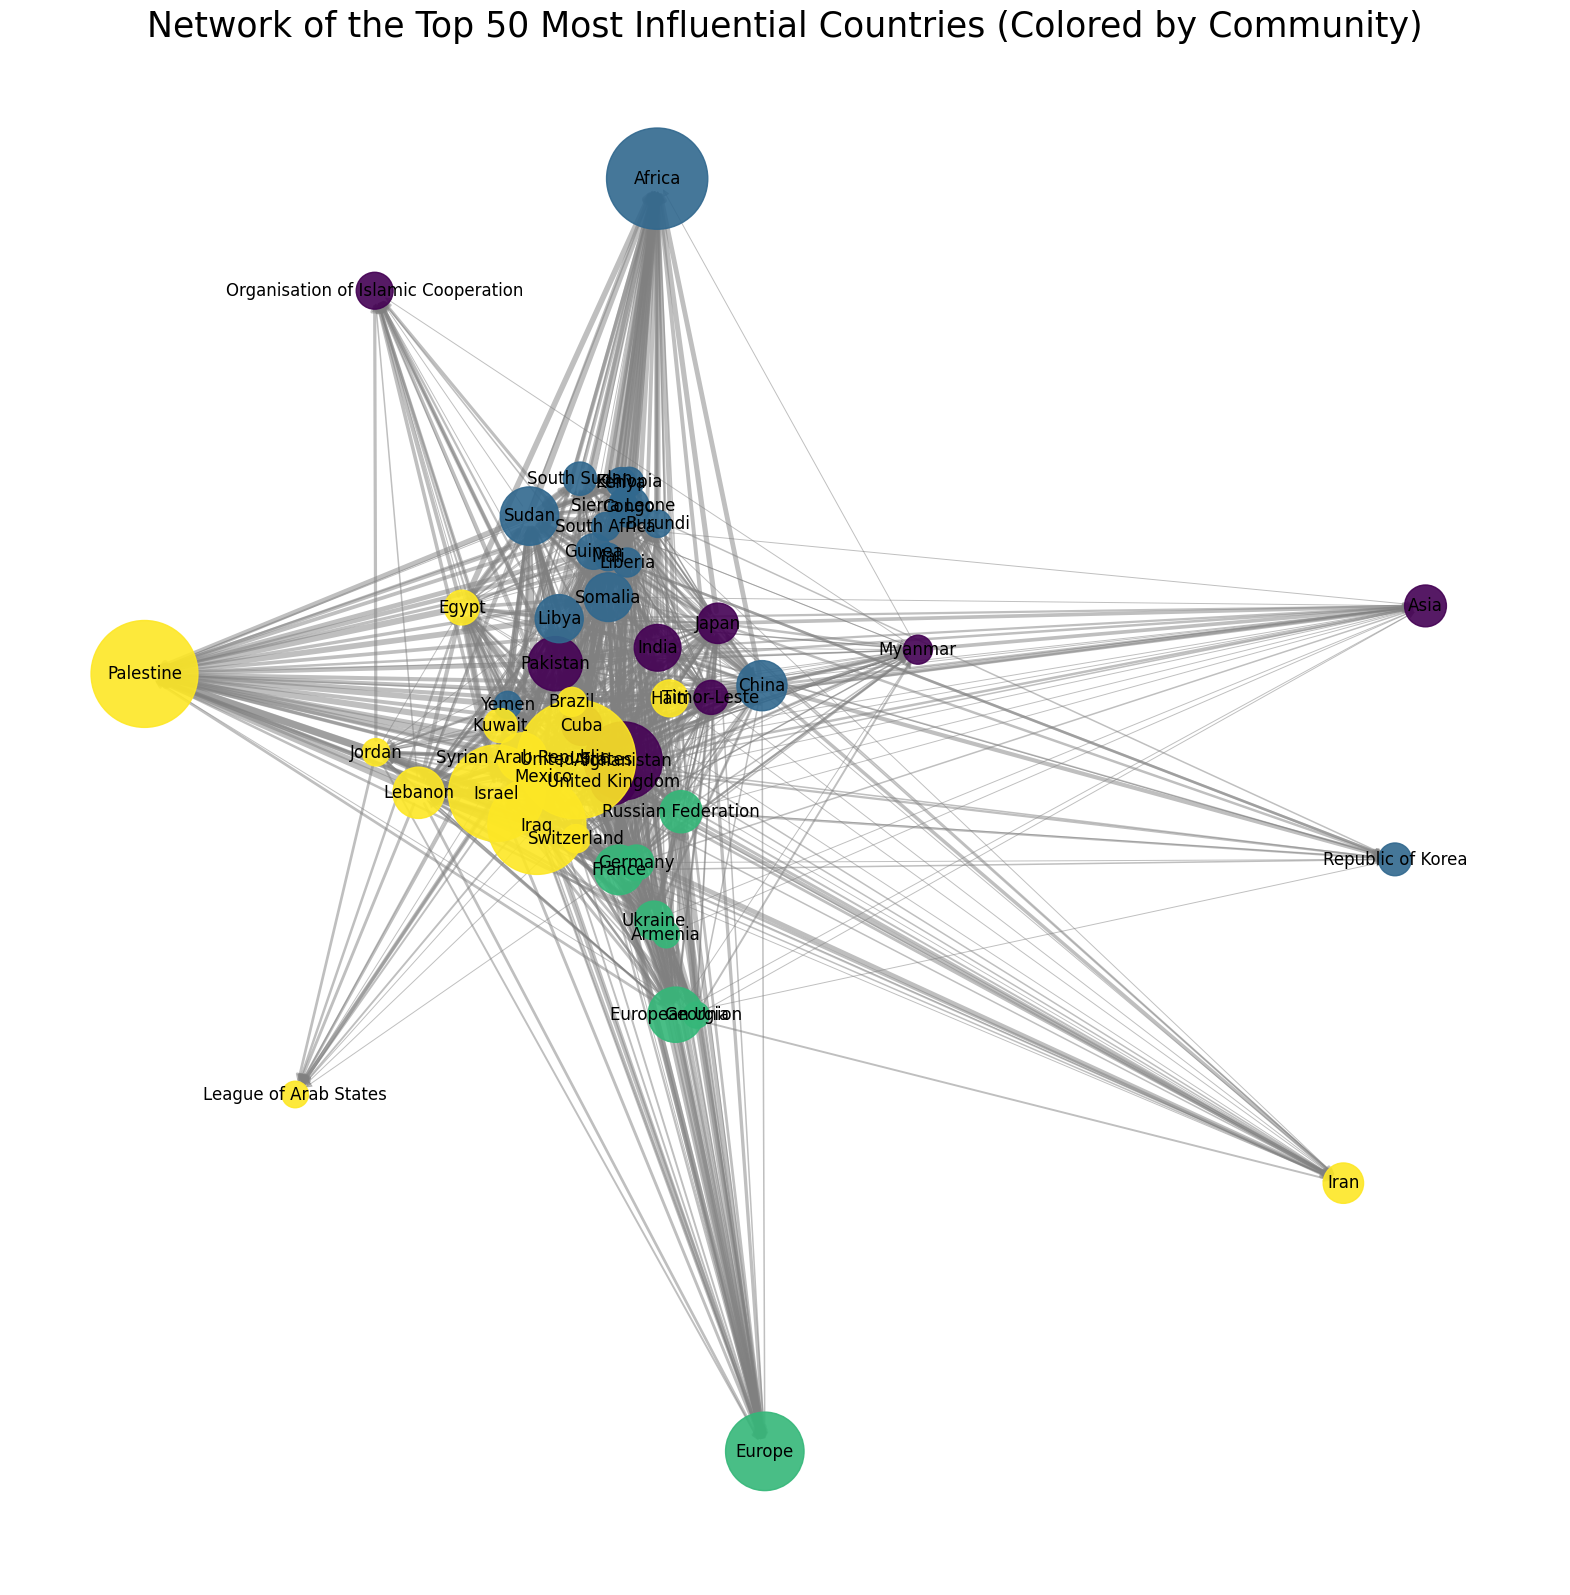

In [ ]:
from networkx.algorithms import community

# STEP 6.1: PREPARE DATA

# Detect communities in the filtered graph for node coloring.
G_undirected = G_top.to_undirected()
communities = community.louvain_communities(G_undirected, weight='weight', seed=123)

# Create a color map to assign a color to each community.
color_map = {}
for i, comm in enumerate(communities):
    for node in comm:
        color_map[node] = i
node_colors = [color_map[node] for node in G_top.nodes()]


# STEP 6.2: CREATE VISUALIZATION

# Set the figure size for the plot.
plt.figure(figsize=(20, 20))

# The "physics part": nx.spring_layout is a force-directed layout.
# It simulates forces to position nodes so that connected nodes are closer
# and central nodes are more prominent.
pos = nx.spring_layout(G_top, k=0.4, iterations=50, seed=42)

# Set node sizes based on their PageRank score.
node_sizes = [pagerank_scores.get(node, 0) * 100000 for node in G_top.nodes()]

# Set edge widths based on the log of their weight.
edge_weights = [np.log1p(G_top[u][v].get('weight', 1)) for u, v in G_top.edges()]

# Draw the network components with the specified visual properties.
nx.draw_networkx_nodes(G_top, pos, node_size=node_sizes, 
                       node_color=node_colors, cmap=plt.cm.viridis, alpha=0.9)

nx.draw_networkx_edges(G_top, pos, width=edge_weights, edge_color="grey", alpha=0.5)

nx.draw_networkx_labels(G_top, pos, font_size=12)

plt.title(f"Network of the Top {G_top.number_of_nodes()} Most Influential Countries (Colored by Community)", fontsize=25)
plt.axis('off') # Hide the axes
plt.show()